In [54]:
from torchvision import transforms, models
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from IPython.display import clear_output
import seaborn as sn
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score
import warnings
warnings.filterwarnings('ignore')

In [55]:
def getTrain(root_dir='train'):
    samples = []
    labels = []
    names = []
    for class_dir in ['1_�⮫�', '4_�����', '2_��\u1ae0', '3_������']:
        full_path = '{}/{}'.format(root_dir, class_dir)
        curr_class = int(class_dir[0]) - 1
        for image_name in os.listdir(full_path):
            img = Image.open('{}/{}'.format(full_path, image_name))
            img.load()
            samples.append(img)
            labels.append(curr_class)
            names.append(image_name)
    random_shuffle = np.random.choice(len(samples), len(samples), replace=False)
    samples = np.array(samples, dtype='object')[random_shuffle]
    labels = np.array(labels)[random_shuffle]
    names = np.array(names)[random_shuffle]
    return samples, labels, names

def getTest(root_dir='test'):
    samples = []
    names = []
    for image_name in os.listdir(root_dir):
        img = Image.open('{}/{}'.format(root_dir, image_name))
        img.load()
        samples.append(img)
        names.append(image_name)
    samples = np.array(samples, dtype='object')
    names = np.array(names)
    return samples, names

In [56]:
print(os.listdir("../input/img_kagl_train"))

['1_�⮫�', '4_�����', '2_��\u1ae0', '3_������']


In [57]:
X_train, y_train, names_train = getTrain('../input/img_kagl_train')
print('Train loaded!')
X_test, names_test = getTest(root_dir='../input/img_kagl_test/test')
print('Test loaded!')

Train loaded!
Test loaded!


In [58]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(X_train, y_train, test_size=0.2)

In [59]:
transformer = transforms.Compose([
    transforms.CenterCrop((400, 400)),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

In [60]:
print('tensoring train')

batch_size = 64

tensor_x = torch.stack([torch.Tensor(transformer(i)) for i in train_data]) # transform to torch tensors
#tensor_y = torch.stack([torch.Tensor(i) for i in train_labels])
tensor_y = torch.from_numpy(np.array(train_labels))

tensor_train = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset

train_load = torch.utils.data.DataLoader(dataset = tensor_train,
                              batch_size = batch_size,
                              shuffle = True) # create your dataloader


print('tensoring test')

tensor_x = torch.stack([torch.Tensor(transformer(i)) for i in test_data]) # transform to torch tensors
#tensor_y = torch.stack([torch.LongTensor(np.array([d[i]])) for i in test_labels])
tensor_y = torch.from_numpy(np.array(test_labels))

tensor_test = torch.utils.data.TensorDataset(tensor_x, tensor_y) # create your datset

test_load = torch.utils.data.DataLoader(dataset = tensor_test,
                             batch_size = batch_size,
                             shuffle = False) # create your dataloader

print('tensoring pred')

tensor_x = torch.stack([torch.Tensor(transformer(i)) for i in X_test]) # transform to torch tensors

tensor_pred = torch.utils.data.TensorDataset(tensor_x) # create your datset

pred_load = torch.utils.data.DataLoader(dataset = tensor_pred,
                             batch_size = batch_size,
                             shuffle = False
                             ) # create your dataloader

tensoring train
tensoring test
tensoring pred


In [61]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(in_features=2048, out_features=1000)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=1000, out_features=4)
        
    def forward(self, X):
        out = self.cnn1(X)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        
        out = out.view(-1, 2048)
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [62]:
def calculate_loss_accuracy(load, model, loss_fn):
    total = 0
    correct = 0
    accuracy = 0
    loss = 0
    for images, labels in load:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        loss += loss_fn(outputs, labels).item()
        
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    
    accuracy = float(correct) / total * 100
    loss /= len(load.dataset)
    return loss, accuracy

In [63]:
def view_graphs(train_accuracy_history, test_accuracy_history, train_loss_history, test_loss_history, title):
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    plt.title(title + 'Accuracy')
    plt.plot(np.arange(len(train_accuracy_history)) + 1, train_accuracy_history, label='train')
    plt.plot(np.arange(len(test_accuracy_history)) + 1, test_accuracy_history, label='test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy, %')
    plt.legend()
    plt.subplot(122)
    plt.title(title + 'Loss')
    plt.plot(np.arange(len(train_loss_history)) + 1, train_loss_history, label='train')
    plt.plot(np.arange(len(test_loss_history)) + 1, test_loss_history, label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

## Графики и визуализация обучения. (1 балл)

In [75]:
model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.01)


train_loss_history = []
test_loss_history = []

train_accuracy_history = []
test_accuracy_history = []

iter = 0
for epoch in range(40):
    for i, (images, labels) in enumerate(train_load):
        iter += 1
        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    train_loss, train_accuracy = calculate_loss_accuracy(train_load, model, loss_fn)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    test_loss, test_accuracy = calculate_loss_accuracy(test_load, model, loss_fn)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    print(epoch, 'Done! Train Loss: {}, Test Loss: {}, Train Accuracy {:.2f}%, Test Accuracy {:.2f}%'.format(train_loss, test_loss, train_accuracy, test_accuracy))

0 Done! Train Loss: 0.015527699216764572, Test Loss: 0.016642416749045114, Train Accuracy 63.16%, Test Accuracy 60.28%
1 Done! Train Loss: 0.013818274150814927, Test Loss: 0.014727433290437002, Train Accuracy 65.03%, Test Accuracy 63.32%
2 Done! Train Loss: 0.012497621844386497, Test Loss: 0.013804986794418264, Train Accuracy 69.18%, Test Accuracy 64.25%
3 Done! Train Loss: 0.011517685268357484, Test Loss: 0.012720821616805602, Train Accuracy 72.16%, Test Accuracy 71.03%
4 Done! Train Loss: 0.010702649124881678, Test Loss: 0.012490216538170788, Train Accuracy 75.38%, Test Accuracy 73.60%
5 Done! Train Loss: 0.010153439815281428, Test Loss: 0.011763301129653075, Train Accuracy 76.08%, Test Accuracy 75.23%
6 Done! Train Loss: 0.009562204316345572, Test Loss: 0.011654274485935675, Train Accuracy 77.66%, Test Accuracy 74.07%
7 Done! Train Loss: 0.009207672037576374, Test Loss: 0.01105298484875777, Train Accuracy 79.36%, Test Accuracy 75.47%
8 Done! Train Loss: 0.008823093249086748, Test Lo

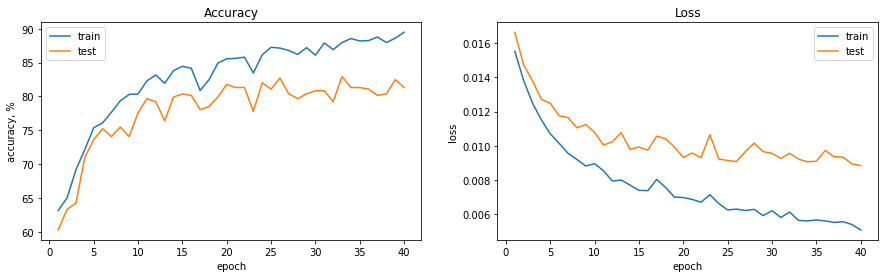

In [76]:
view_graphs(train_accuracy_history, test_accuracy_history, train_loss_history, test_loss_history, title='')

## Контроль за переобучением. (1 балл)
#### Новая модель обучена ниже.

Поставив модель обучаться на сранительно большое количество эпох мы можем получить информацию о переобучении модели.
Внимательно изучив графики легко понять, что где-то в районе 7 эпохи, начался процесс называемый переобучением. Его легко идентифицировать по Loss и Accuracy Графикам, найдя на них место, где кривые соответствующие результатам на train и test начинают вести себя следующим образом. Accuracy на train продолжает монотонно увеличиваться, при условии что на test оно либо остается неизменным, либо вообще падает. Мы видим что в районе 10-15 эпохи началось стабильное флуктуирование accuracy на test-e в районе 80%. С Loss графиками ситуация совершенно обратная, в плане идентификации переобучения. Loss на test-выборке либо перестаёт уменьшаться, либо начинает даже увеличиваться, в то же время как Loss на train продолжает падать вниз вплоть до 0. Ну и становится очевидно что в районе 7 эпохи имеет место быть такая тенденция. Таким образом мы обучаем нашу модель на 7-10 эпохах, и отправляем своё решение в kaggle, избавившись от самой большой проблемы машинного обучения - проблемы переобучения.

0 Done! Train Loss: 0.01502683134803995, Test Loss: 0.0160584887054479, Train Accuracy 65.20%, Test Accuracy 62.38%
1 Done! Train Loss: 0.012805939940681235, Test Loss: 0.014307186843078827, Train Accuracy 69.94%, Test Accuracy 67.52%
2 Done! Train Loss: 0.011595949966307969, Test Loss: 0.012962318190904421, Train Accuracy 71.64%, Test Accuracy 69.86%
3 Done! Train Loss: 0.010499749790158188, Test Loss: 0.012010209332002657, Train Accuracy 75.91%, Test Accuracy 75.00%
4 Done! Train Loss: 0.009628570811790332, Test Loss: 0.01142752281973295, Train Accuracy 78.77%, Test Accuracy 74.77%
5 Done! Train Loss: 0.009171557095315721, Test Loss: 0.011193778052508273, Train Accuracy 78.60%, Test Accuracy 75.47%
6 Done! Train Loss: 0.008821306382006372, Test Loss: 0.010780570802287521, Train Accuracy 81.46%, Test Accuracy 77.80%
7 Done! Train Loss: 0.008539400498072306, Test Loss: 0.010415929848345641, Train Accuracy 81.58%, Test Accuracy 77.80%
8 Done! Train Loss: 0.008295278608450415, Test Loss:

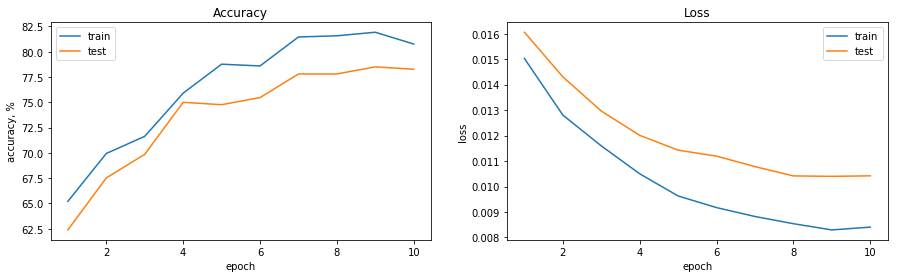

In [77]:
model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.01)

train_loss_history = []
test_loss_history = []

train_accuracy_history = []
test_accuracy_history = []

iter = 0
for epoch in range(10):
    for i, (images, labels) in enumerate(train_load):
        iter += 1
        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    train_loss, train_accuracy = calculate_loss_accuracy(train_load, model, loss_fn)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    test_loss, test_accuracy = calculate_loss_accuracy(test_load, model, loss_fn)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    print(epoch, 'Done! Train Loss: {}, Test Loss: {}, Train Accuracy {:.2f}%, Test Accuracy {:.2f}%'.format(train_loss, test_loss, train_accuracy, test_accuracy))

view_graphs(train_accuracy_history, test_accuracy_history, train_loss_history, test_loss_history, title='')

In [78]:
def get_preds(pred_load, model):
    preds = []
    for images in pred_load:
        images = images[0]
        images = images
        model.training = False
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        preds.append(predicted)

    ans = []
    for i in range(len(preds)):
        for j in range(len(preds[i])):
            ans.append(preds[i][j])
    return np.array(ans)

## Confusion Матрица. (1 балл)

In [79]:
classes = ['Столы',  'Кресла', 'Диваны', 'Стулья']
preds_train = get_preds(train_load, model).reshape(-1, 1)
preds_validation = get_preds(test_load, model).reshape(-1, 1)

In [80]:
print(np.array(train_labels).shape, np.array(preds_train).reshape(-1, 1).shape)

(1710,) (1710, 1)


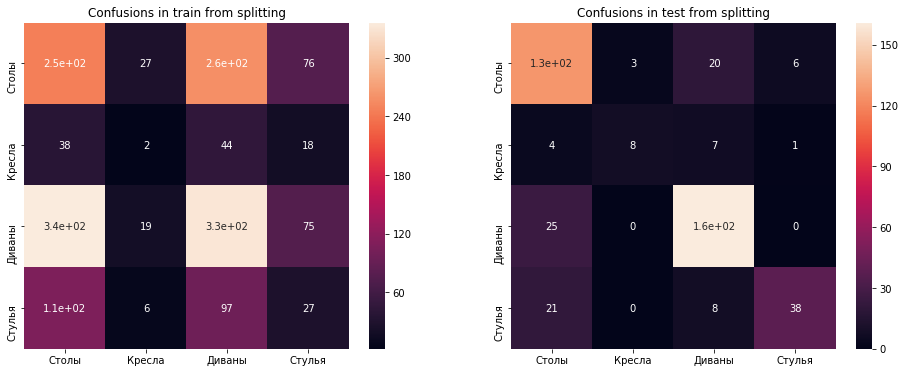

In [81]:
plt.figure(figsize=(16,6))

train_conf_matrix = confusion_matrix(train_labels, preds_train)
validation_conf_matrix = confusion_matrix(test_labels,preds_validation)

plt.subplot(1, 2, 1)
plt.title('Confusions in train from splitting')
sn.heatmap(pd.DataFrame(train_conf_matrix, index=classes, columns=classes), annot=True)

plt.subplot(1, 2, 2)
plt.title('Confusions in test from splitting')
sn.heatmap(pd.DataFrame(validation_conf_matrix, index=classes, columns=classes), annot=True)

In [82]:
def saver(path, res):
    with open(path, 'w') as out:
        print('Image,Type', file=out)
        for i in range(len(res)):
            print('{i},{res}'.format(i = i + 1, res=res[i]), file=out)

In [ ]:
ans = get_preds(pred_load, model)

In [ ]:
answers = pd.DataFrame()
answers['Image'] = names_test
answers['Type'] = ans + 1
answers.to_csv('predict2.csv', index=False)

## Вопросы Экзамена (1 балл)

#### 1) А
#### 2) Б
#### 3) А
#### 4) В
#### 5) Б
#### 6) Б
#### 7) Б
#### 8) A

